In [9]:
import numpy as np
import pandas as pd
import cv2 as cv
import os
import glob
#from google.colab.patches import cv2_imshow
import matplotlib
import matplotlib.pyplot

# a) Calibrate the intrinsic parameters and lens distortion of the camera.
# b) Calibrate the extrinsic parameters of the camera setup (or instead, use the extrinsic image to manually measure the dimensions of a black square of the chessboard in pixels. In this way, you will know the conversion between pixel to millimeter). 

 Camera matrix:
[[1.32164961e+03 0.00000000e+00 9.88299668e+02]
 [0.00000000e+00 1.32444624e+03 6.42259078e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

 Distortion coefficient:
[[-3.44269790e-01  9.00566070e-02  9.45585473e-05 -3.97940160e-04
  -3.15658830e-03]]

 Rotation Vectors:
(array([[ 0.2937715 ],
       [-0.19838341],
       [ 1.59740416]]), array([[-0.01542777],
       [-0.01092832],
       [-1.53293415]]), array([[-0.46385959],
       [-0.4067831 ],
       [-1.49529627]]), array([[-0.45486637],
       [-0.39438828],
       [-1.48460491]]), array([[ 0.55080612],
       [ 0.47229449],
       [-1.24281084]]), array([[ 0.22314302],
       [ 0.60213945],
       [-1.23724149]]), array([[ 0.41661222],
       [ 0.75681605],
       [-1.96121147]]), array([[-0.00280697],
       [-0.11140255],
       [-1.14997674]]), array([[ 0.40358211],
       [ 0.77612666],
       [-1.98557335]]), array([[-0.5413167 ],
       [-0.33847105],
       [-0.39833958]]), array([[ 0.00463378],
    

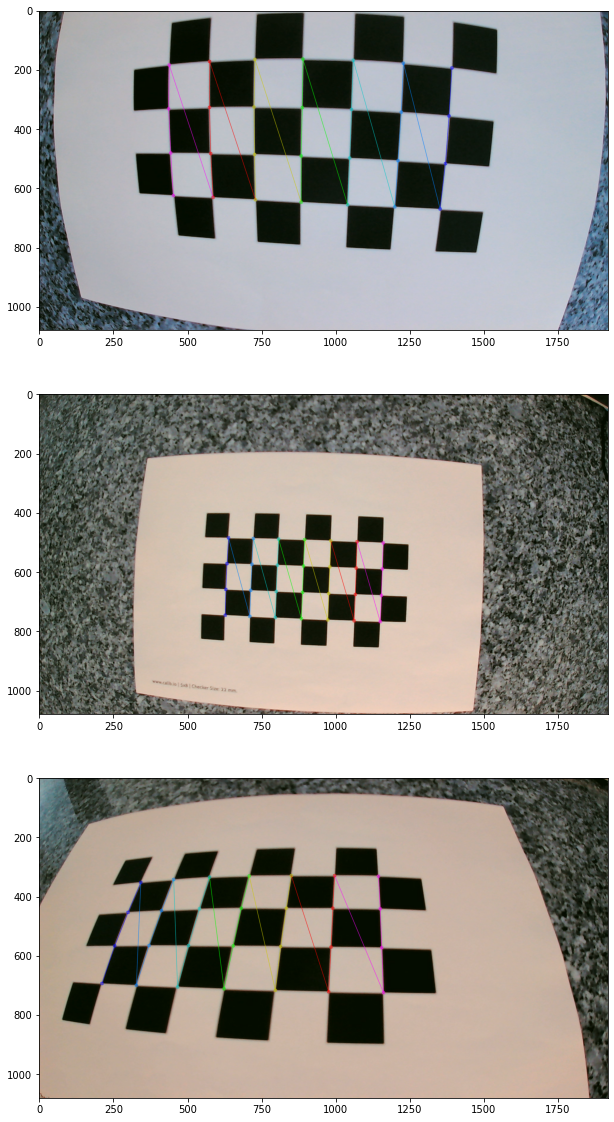

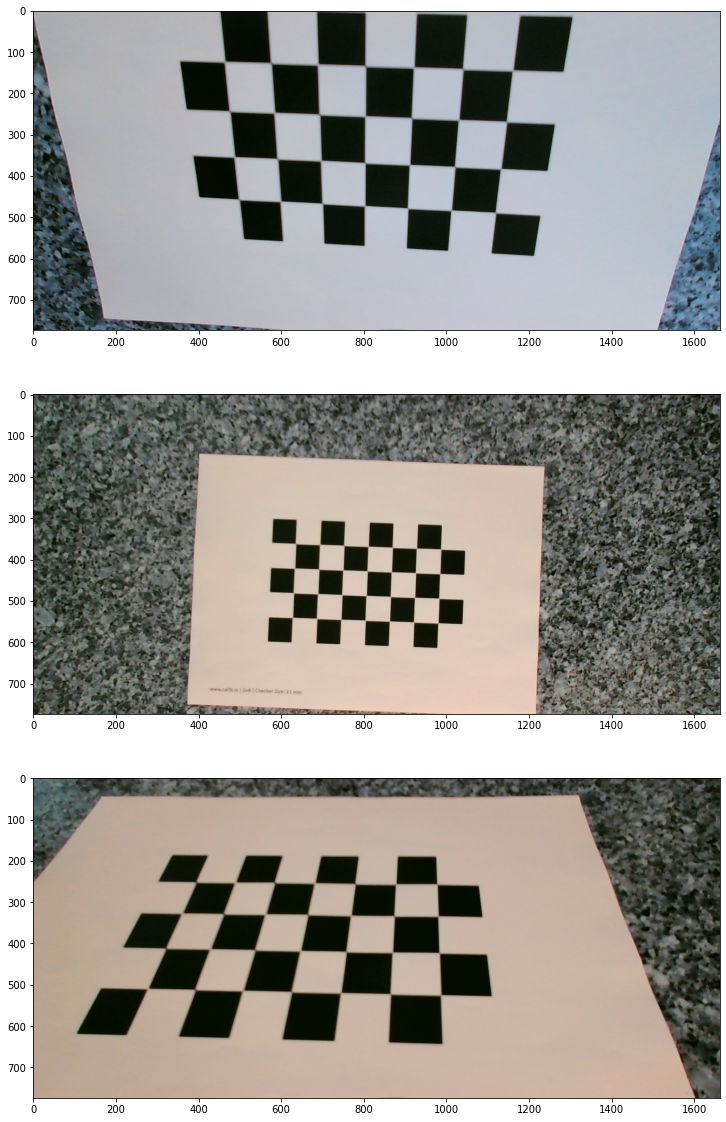

In [180]:
fig, axes = matplotlib.pyplot.subplots(3, 1, figsize = (20,20))


# Define the dimensions of checkerboard
CHECKERBOARD = (4, 7)
 
 
# stop the iteration when specified
# accuracy, epsilon, is reached or
# specified number of iterations are completed.
criteria = (cv.TERM_CRITERIA_EPS +
            cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
 
 
# Vector for 3D points
threedpoints = []
 
# Vector for 2D points
twodpoints = []
 
 
#  3D points real world cooROInates
objectp3d = np.zeros((1, CHECKERBOARD[0]* CHECKERBOARD[1], 3), np.float32)
objectp3d[0, :, :2] = np.mgrid[0:CHECKERBOARD[0],
                               0:CHECKERBOARD[1]].T.reshape(-1, 2)
prev_img_shape = None
 
 
# Extracting path of individual image stored
# in a given directory. Since no path is
# specified, it will take current directory
# jpg files alone
#images = glob.glob('./drive/MyDrive/IntrinsicCalibration/*.png')
images = glob.glob('./Data/Cali/*.png')
i=0
for filename in images:
    image = cv.imread(filename)
    grayColor = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
 
    # Find the chess board corners
    # If desired number of corners are
    # found in the image then ret = true
    ret, corners = cv.findChessboardCorners(grayColor, CHECKERBOARD,
                                            cv.CALIB_CB_ADAPTIVE_THRESH + cv.CALIB_CB_FAST_CHECK + cv.CALIB_CB_NORMALIZE_IMAGE)
 
    # If desired number of corners can be detected then,
    # refine the pixel cooROInates and display
    # them on the images of checker board
    if ret == True:
        threedpoints.append(objectp3d)
 
        # Refining pixel coordinates
        # for given 2d points.
        corners2 = cv.cornerSubPix(grayColor, corners, (11, 11), (-1, -1), criteria)
 
        twodpoints.append(corners2)
 
        # Draw and display the corners
        image = cv.drawChessboardCorners(image,
                                          CHECKERBOARD,
                                          corners2, ret)
 
    if (i < 3):
        axes[i].imshow(image)
    i+=1


# Perform camera calibration by
# passing the value of above found out 3D points (threedpoints)
# and its corresponding pixel cooROInates of the
# detected corners (twodpoints)
ret, matrix, distortion, r_vecs, t_vecs = cv.calibrateCamera(
    threedpoints, twodpoints, grayColor.shape[::-1], None, None)


# Displaying required output

print(" Camera matrix:")
print(matrix)
 
print("\n Distortion coefficient:")
print(distortion)
 
print("\n Rotation Vectors:")
print(r_vecs)
 
print("\n Translation Vectors:")
print(t_vecs)


#However first, we can refine the camera matrix
#based on a free scaling parameter using cv.getOptimalNewCameraMatrix()

#images = glob.glob('./drive/MyDrive/IntrinsicCalibration/*.png')
fig, axes = matplotlib.pyplot.subplots(3, 1, figsize = (20,20))

images = glob.glob('./Data/Cali/*.png')
i = 0

for filename in images:
  img = cv.imread(filename)
  h,  w = img.shape[:2]
  newcameramtx, roi = cv.getOptimalNewCameraMatrix(matrix, distortion, (w,h), 1, (w,h))

  # undistort
  dst = cv.undistort(img, matrix, distortion, None, newcameramtx)
  # crop the image
  x, y, w, h = roi
  dst = dst[y:y+h, x:x+w]
  if (i < 3):
    axes[i].imshow(dst)
  i += 1

In [181]:
def pixelsToMM (imgRef):

  h,  w = imgRef.shape[:2]
  newcameramtx, ROI = cv.getOptimalNewCameraMatrix(matrix, distortion, (w,h), 1, (w,h))
  # undistort
  dst = cv.undistort(imgRef, matrix, distortion, None, newcameramtx)

  # crop the image
  x, y, w, h = ROI
  dst = dst[y:y+h, x:x+w]
  
  ROI = dst[0:700, 360:1350]
  mask = cv.inRange(ROI, np.array([0,0,0], np.uint8),np.array([80,80,80], np.uint8))
  #cv2_imshow(mask)

  pixels = cv.countNonZero(mask)
  pixels_square = float(pixels)/20.0

  return pixels_square/(21*21)

  #return cv.bitwise_and(imgRef,imgRef,mask = mask)

In [182]:
checker = cv.imread("./Data/White/extrinsic.png")
#checker_hsv = cv.cvtColor(checker, cv.COLOR_BGR2HSV)
#cv2_imshow(checker)
const = pixelsToMM (checker)
print("Constante Pixels/mm2: {0:.3f}".format(const))

Constante Pixels/mm2: 13.735


# c) Consider only the images retrieved from a White Background. Implement the functions described above.

## I. Define a ROI (region of interest);


A ROI escolhida foi de [0:700, 360:1350], pois, como será visto mais adiante, foi ajustada mediante as dimensões da folha e é  aque apresenta uma maior centralização dos M&Ms na Imagem

## II. Calculate the color distribution (up to 4);
## III. Determine the shape area for the chocolate peanuts in pixels;
## IV. Determine the shape area for chocolate peanuts in millimeters and group by color;
## V. Show a histogram of the shape areas of the chocolate peanuts for the entire sample;

In [183]:
#Range for red color
#red_lower = np.array([0,80,50], np.uint8)
red_lower = np.array([0,90,130], np.uint8)
red_upper = np.array([13,255,255], np.uint8)

#Range for blue color
blue_lower = np.array([95,90,75], np.uint8)
blue_upper = np.array([120,255,255], np.uint8)

#Range for yellow color
yellow_lower = np.array([20,80,40], np.uint8)
yellow_upper = np.array([31,255,255], np.uint8)

#Range for green color
green_lower = np.array([40,110,30], np.uint8)
green_upper = np.array([88,255,255], np.uint8)

#Range for brown color
#brown_lower = np.array([15*255/100,15*255/100,5*255/100], np.uint8)
#brown_upper = np.array([30*255/100,25*255/100,15*255/100], np.uint8)
brown_lower = np.array([0,60,30], np.uint8)
brown_upper = np.array([20,255,200], np.uint8)

In [184]:
def findObjects(img, mask, area_min = 700, objName = "Object", IDBox_Color_BGR = (255, 0, 0)):
  
  cnt = 0
  img_ID_Box = img.copy()

  numero_pixels = cv.countNonZero(mask)

  #img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
  #image_pixels = img_gray.shape[0] * img_gray.shape[1]
  #mask_ratio = (numero_pixels / image_pixels) * 100


  # Find contours
  contours, hierarchy = cv.findContours(mask,cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)

  for pic, c in enumerate(contours):
    area = cv.contourArea(c)
    if area >= area_min and area <= 5000:
      x,y,w,h = cv.boundingRect(c)
      ID_Box = cv.rectangle(img_ID_Box,(x,y),(x+w,y+h),IDBox_Color_BGR,2)
      cv.putText(img_ID_Box, objName, (x,y), cv.FONT_HERSHEY_SIMPLEX, 1.0, IDBox_Color_BGR, 2)
      cnt = cnt + 1
  
  return (img_ID_Box, int(cnt), numero_pixels)

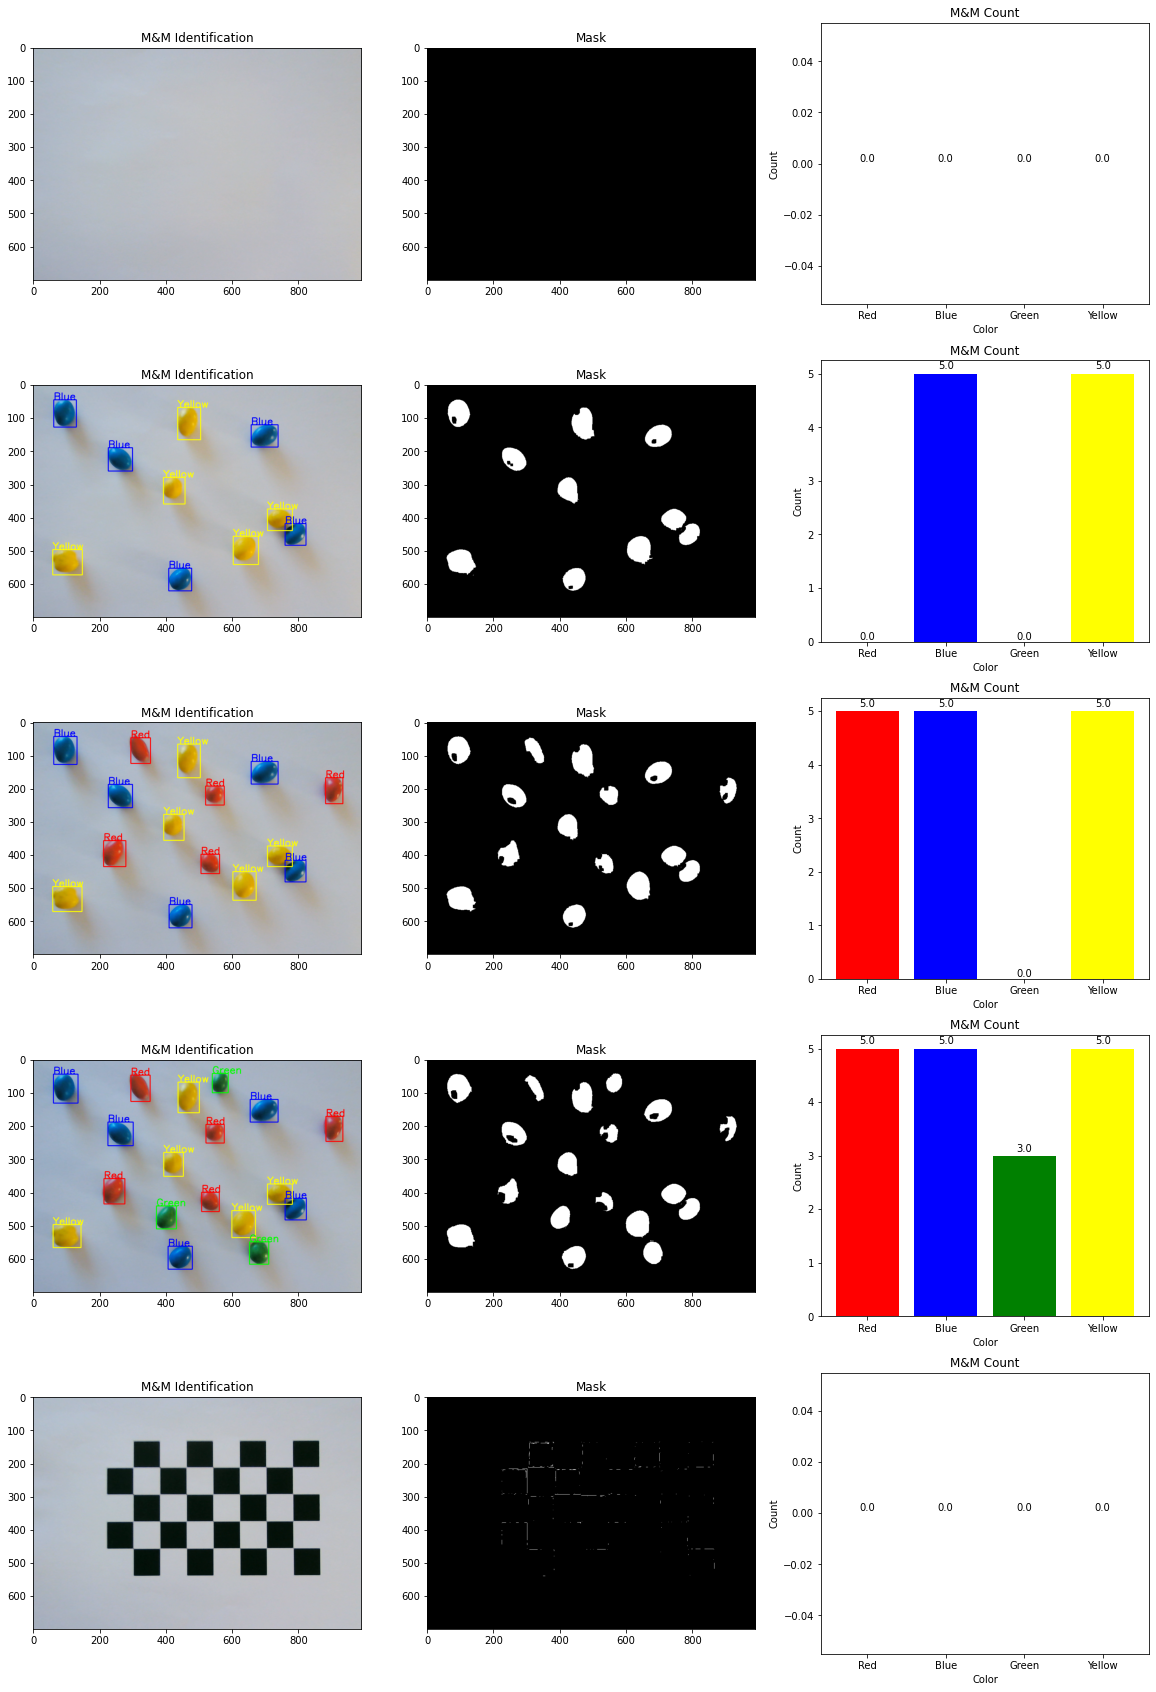

In [185]:

images = glob.glob('./Data/White/*.png')

fig, axes = matplotlib.pyplot.subplots(5, 3, figsize = (20,30), gridspec_kw={"width_ratios": [1, 1, 1]})

area = []
contagem = []
img_ID = []
kernel = np.ones((8, 8), "uint8")
i=0
for filename in images:
  img = cv.imread(filename)
  h,  w = img.shape[:2]
  newcameramtx, ROI = cv.getOptimalNewCameraMatrix(matrix, distortion, (w,h), 1, (w,h))
  # undistort
  dst = cv.undistort(img, matrix, distortion, None, newcameramtx)

  # crop the image
  x, y, w, h = ROI
  dst = dst[y:y+h, x:x+w]
  
  ROI = dst[0:700, 360:1350]

  hsv = cv.cvtColor(ROI, cv.COLOR_BGR2HSV)
  

  #Define masks
  red_mask = cv.inRange(hsv, red_lower, red_upper)
  red_mask = cv.dilate(red_mask, kernel)
  red_mask = cv.erode(red_mask, kernel)


  blue_mask = cv.inRange(hsv, blue_lower, blue_upper)
  blue_mask = cv.dilate(blue_mask, kernel)
  blue_mask = cv.erode(blue_mask, kernel)

  yellow_mask = cv.inRange(hsv, yellow_lower, yellow_upper)
  yellow_mask = cv.dilate(yellow_mask, kernel)
  yellow_mask = cv.erode(yellow_mask, kernel)


  green_mask = cv.inRange(hsv, green_lower, green_upper)
  green_mask = cv.dilate(green_mask, kernel)
  green_mask = cv.erode(green_mask, kernel)


                                                                
  (img_ID_Box, blue_cnt, blue_mask_area) = findObjects(ROI, blue_mask, objName = "Blue", IDBox_Color_BGR = (255, 0, 0))
  (img_ID_Box, red_cnt, red_mask_area) = findObjects(img_ID_Box, red_mask, objName = "Red", IDBox_Color_BGR = (0, 0, 255))
  (img_ID_Box, yellow_cnt, yellow_mask_area) = findObjects(img_ID_Box, yellow_mask, objName = "Yellow", IDBox_Color_BGR = (0, 255, 255))
  (img_ID_Box, green_cnt, green_mask_area) = findObjects(img_ID_Box, green_mask, objName = "Green", IDBox_Color_BGR = (0, 255, 0))


  img_ID_Box = cv.cvtColor(img_ID_Box, cv.COLOR_BGR2RGB)

  img_ID.append(img_ID_Box.copy())
  
  area.append([])
  area[i].append(red_mask_area)
  area[i].append(blue_mask_area)
  area[i].append(green_mask_area)
  area[i].append(yellow_mask_area)
  
  contagem.append([])
  contagem[i].append(red_cnt)
  contagem[i].append(blue_cnt)
  contagem[i].append(green_cnt)
  contagem[i].append(yellow_cnt)
  
  axes[i][0].imshow(img_ID_Box)
  axes[i][0].set_title("M&M Identification")
  
  axes[i][1].imshow(blue_mask | red_mask | yellow_mask | green_mask, cmap = "gray")
  axes[i][1].set_title("Mask")
  
  plot = axes[i][2].bar(['Red', 'Blue', 'Green', 'Yellow'], [red_cnt, blue_cnt, green_cnt, yellow_cnt], color = ['red', 'blue', 'Green', 'yellow'])
  
  axes[i][2].set_xlabel("Color")
  axes[i][2].set_ylabel("Count")
  axes[i][2].set_title("M&M Count")
  #axes[i][2].bar(['Red', 'Blue', 'Green', 'Yellow'], [red_mask_area, blue_mask_area, green_mask_area, yellow_mask_area], color = ['red', 'blue', 'Green', 'yellow'])
  for rect in plot:
        height = rect.get_height()
        axes[i][2].text(rect.get_x() + rect.get_width()/2., 1.01*height,
                '%0.1f' % height, ha='center', va='bottom')
  
  i+=1
  

Text(0.5, 1.0, 'M&M Count by Size')

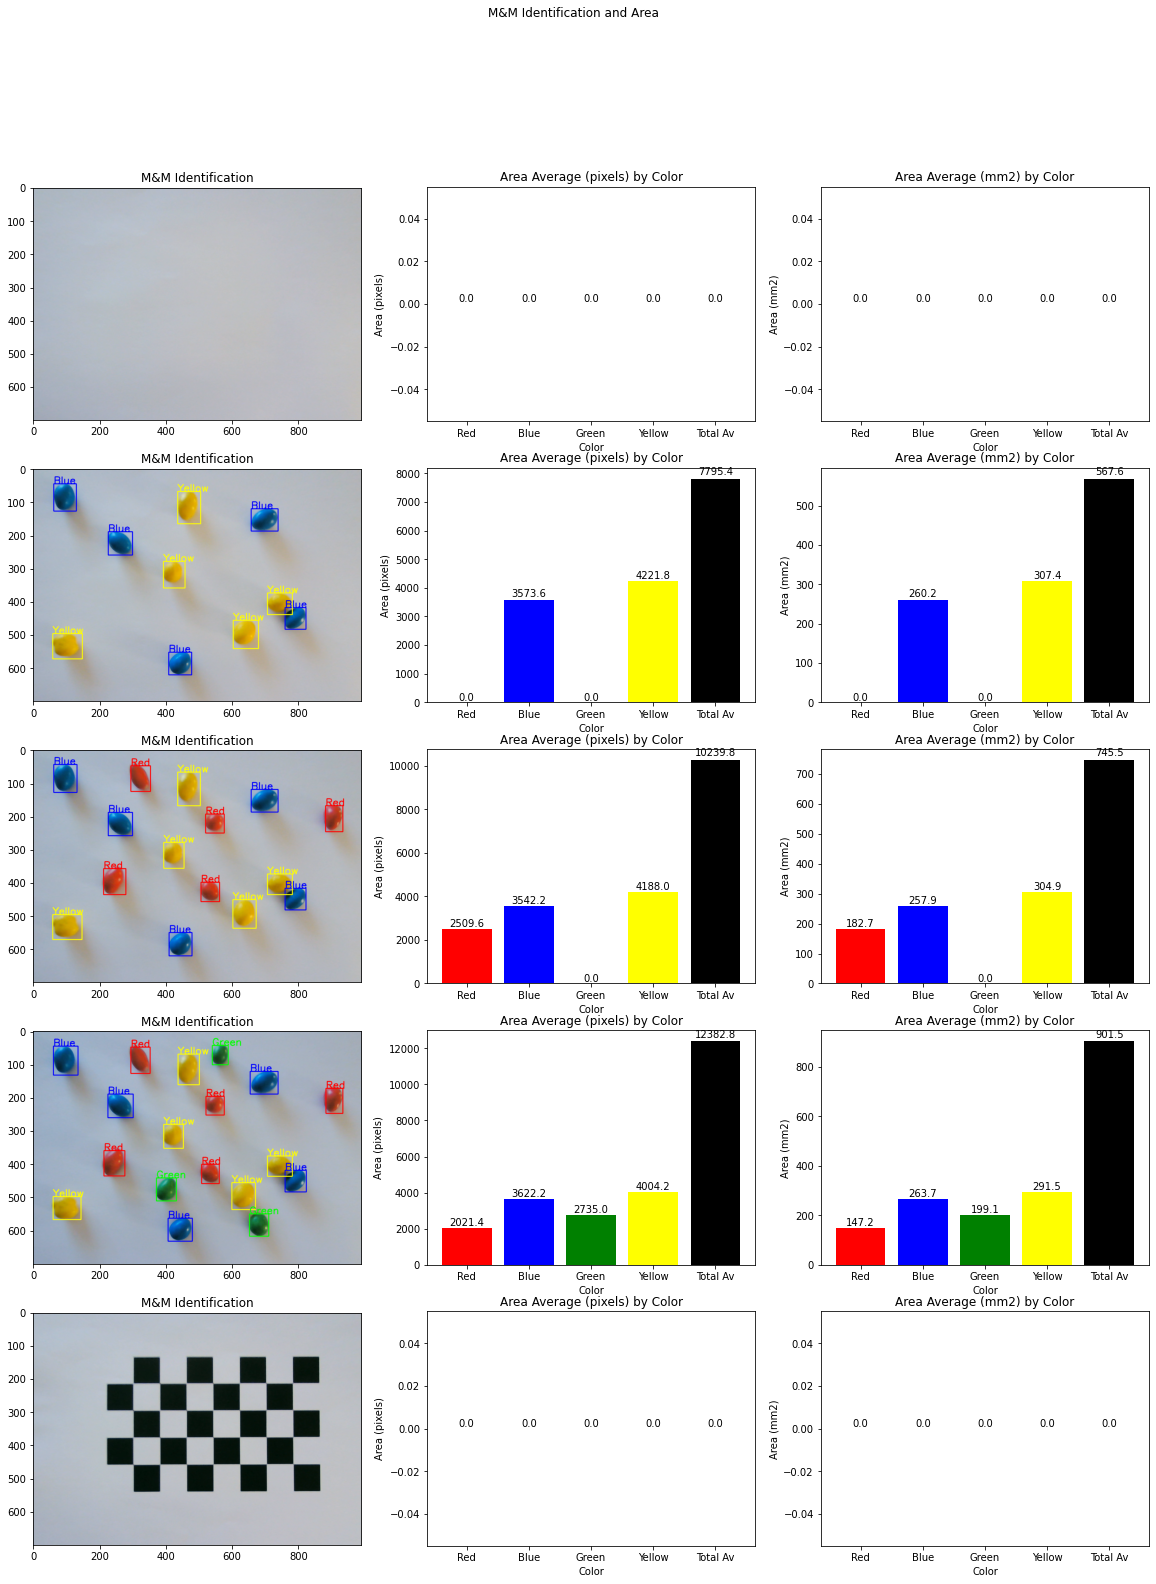

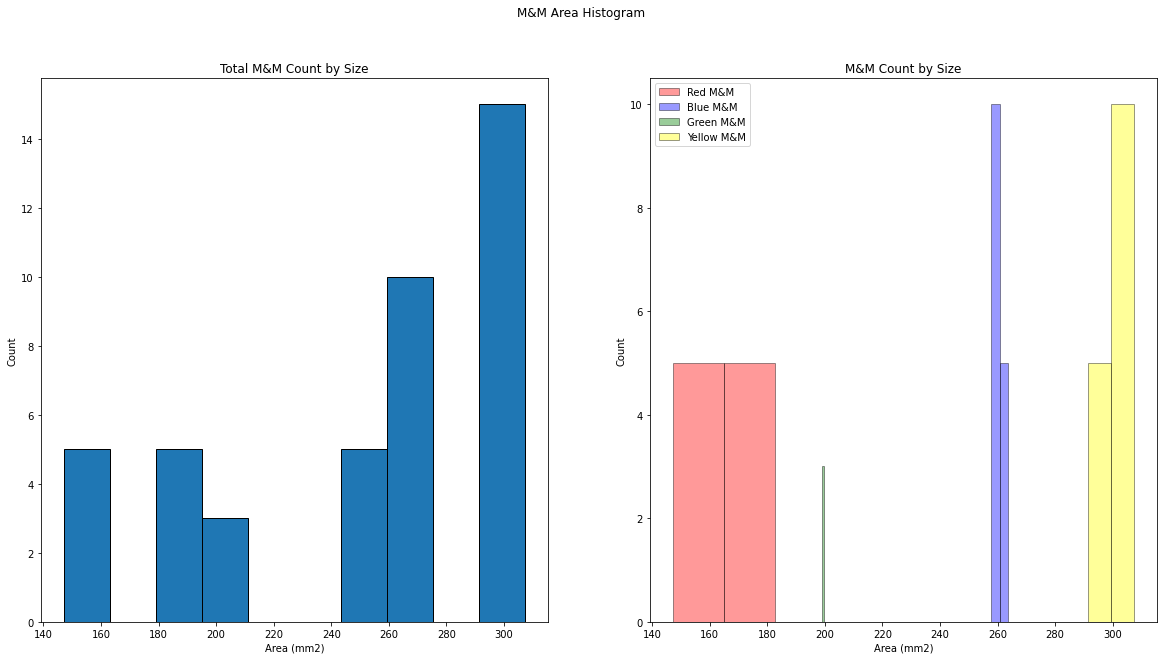

In [186]:
images = glob.glob('./Data/White/*.png')

fig, axes = matplotlib.pyplot.subplots(5, 3, figsize = (20,25), gridspec_kw={"width_ratios": [1, 1, 1]})
fig.suptitle("M&M Identification and Area")
fig_hist, axes_hist = matplotlib.pyplot.subplots(1, 2, figsize = (20,10))
fig_hist.suptitle("M&M Area Histogram")
areas = []
areas_color = [[],[],[],[]]

i=0
for filename in images:
  img = cv.imread(filename)
  h,  w = img.shape[:2]
  newcameramtx, ROI = cv.getOptimalNewCameraMatrix(matrix, distortion, (w,h), 1, (w,h))
  # undistort
  dst = cv.undistort(img, matrix, distortion, None, newcameramtx)

  # crop the image
  x, y, w, h = ROI
  dst = dst[y:y+h, x:x+w]
  
  ROI = dst[0:700, 360:1350]


  axes[i][0].imshow(img_ID[i])
  axes[i][0].set_title("M&M Identification")

  if(contagem[i][0] > 0):
      area_red_pixels = area[i][0]/contagem[i][0]
  else:
      area_red_pixels = 0
  if(contagem[i][1] > 0):
      area_blue_pixels = area[i][1]/contagem[i][1]
  else:
      area_blue_pixels = 0    
  if(contagem[i][2] > 0):
      area_greeen_pixels = area[i][2]/contagem[i][2]
  else:
      area_greeen_pixels = 0
  if(contagem[i][3] > 0):
      area_yellow_pixels = area[i][3]/contagem[i][3]
  else:
      area_yellow_pixels = 0
  
  total = area_red_pixels + area_blue_pixels + area_greeen_pixels + area_yellow_pixels
  
  rects = axes[i][1].bar(['Red', 'Blue', 'Green', 'Yellow', "Total Av"], [area_red_pixels, area_blue_pixels, area_greeen_pixels, area_yellow_pixels, total], color = ['red', 'blue', 'Green', 'yellow', "black"])
  axes[i][1].set_title("Area Average (pixels) by Color")
  axes[i][1].set_ylabel("Area (pixels)")
  axes[i][1].set_xlabel("Color")
  for rect in rects:
        height = rect.get_height()
        axes[i][1].text(rect.get_x() + rect.get_width()/2., 1.01*height,
                '%0.1f' % height, ha='center', va='bottom')
  
  areas.extend(area_red_pixels/const for _ in range(contagem[i][0]))
  areas_color[0].extend(area_red_pixels/const  for _ in range(contagem[i][0]))
  
  areas.extend(area_blue_pixels/const for _ in range(contagem[i][1]))
  areas_color[1].extend(area_blue_pixels/const for _ in range(contagem[i][1]))
  
  #print(area_greeen_pixels/const for _ in range(contagem[i][2]))
  
  areas.extend(area_greeen_pixels/const for _ in range(contagem[i][2]))
  areas_color[2].extend(area_greeen_pixels/const for _ in range(contagem[i][2]))
 
  areas.extend(area_yellow_pixels/const for _ in range(contagem[i][3]))
  areas_color[3].extend(area_yellow_pixels/const for _ in range(contagem[i][3]))


  rects = axes[i][2].bar(['Red', 'Blue', 'Green', 'Yellow', "Total Av"], [area_red_pixels/const, area_blue_pixels/const, area_greeen_pixels/const, area_yellow_pixels/const, total/const], color = ['red', 'blue', 'Green', 'yellow', "black"])
  axes[i][2].set_title("Area Average (mm2) by Color")
  axes[i][2].set_ylabel("Area (mm2)")
  axes[i][2].set_xlabel("Color")
  for rect in rects:
        height = rect.get_height()
        axes[i][2].text(rect.get_x() + rect.get_width()/2., 1.01*height,
                '%0.1f' % height, ha='center', va='bottom')
  
  i+=1


axes_hist[0].hist(x = areas, density = False, edgecolor="black")
axes_hist[0].set_xlabel("Area (mm2)")
axes_hist[0].set_ylabel("Count")
axes_hist[0].set_title("Total M&M Count by Size")

hist1 = axes_hist[1].hist(x = areas_color[0], density = False, bins = 2, alpha = 0.4, color = "red", edgecolor="black", label="Red M&M")
hist2 = axes_hist[1].hist(x = areas_color[1], density = False, bins = 2, alpha = 0.4, color = "blue", edgecolor="black", label="Blue M&M")
hist3 = axes_hist[1].hist(x = areas_color[2], density = False, bins = 2, alpha = 0.4, color = "green", edgecolor="black", label="Green M&M")
hist4 = axes_hist[1].hist(x = areas_color[3], density = False, bins = 2, alpha = 0.4, color = "yellow", edgecolor="black", label="Yellow M&M")

axes_hist[1].legend()
axes_hist[1].set_xlabel("Area (mm2)")
axes_hist[1].set_ylabel("Count")
axes_hist[1].set_title("M&M Count by Size")


## VI. Provide some recommendations that the M&M factory should take into consideration to improve the performance of the quality assurance process based on image processing (e.g., imaging setup, calibration process and photometric effects).

De forma a melhorar a qualidade da inspeção, a fábrica de M&Ms deve:
* Iluminar uniformemente os M&Ms para que não existam reflexos de luz na sua superfície nem sombras. Esses dois fatores influenciam muito a inspeção dos M&Ms, pois dificultam a segmentação por cor e o cálculo das áreas dos M&Ms.
* Escolher preferencialmente backgrounds de cor sólida, branca ou preta. Com um fundo de cor única conseguimos analisar os M&Ms mais precisamente, pois não precisamos de lidar com o Noise que um fundo multicolor trás.

# d)  Consider the images retrieved from a Grey Background and repeat the previous point without defining a region of interest.

Text(0.5, 1.0, 'Median Filter 17x17')

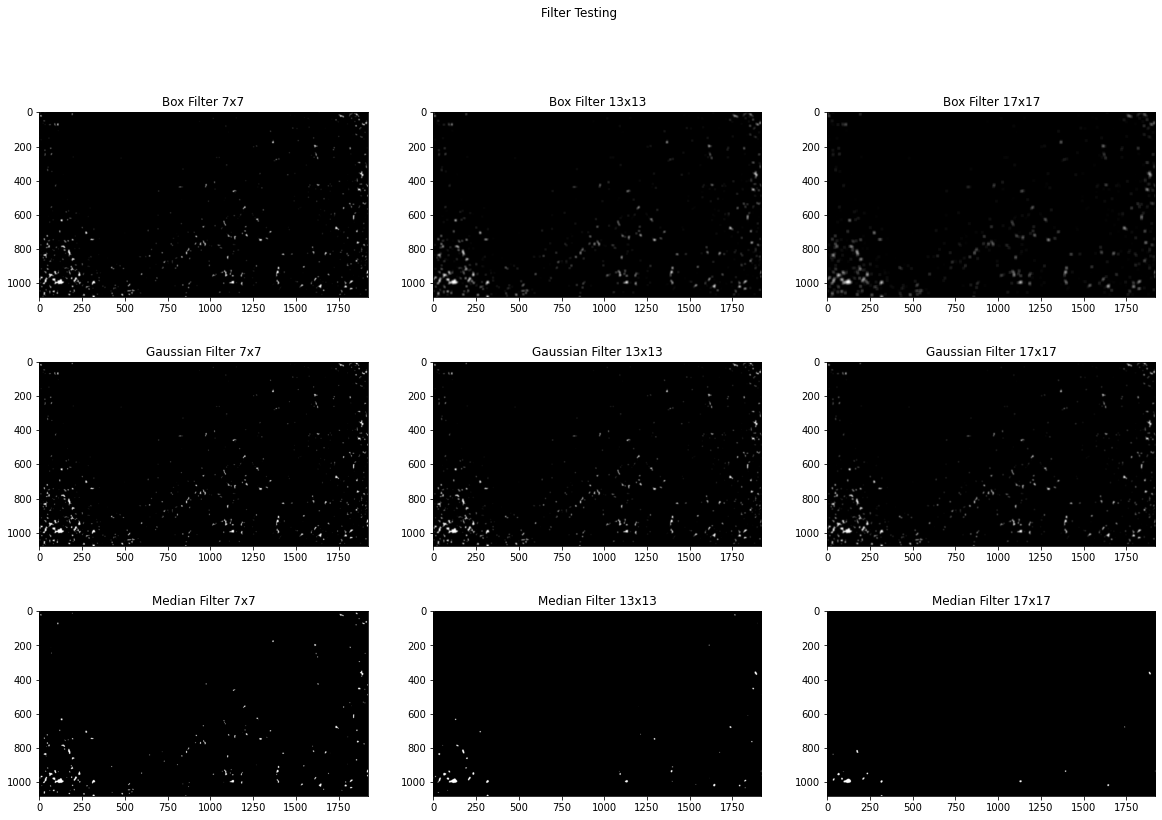

In [187]:
fig_test, axes_test = matplotlib.pyplot.subplots(3, 3, figsize = (20,13))
fig_test.suptitle("Filter Testing")

kernel_dilate = np.ones((7, 7), "uint8")
kernel_erode = np.ones((10, 10), "uint8")

noise = cv.imread("./Data/Grey/calib_img 0.png")

#Define masks
red_mask = cv.inRange(noise, red_lower, red_upper)
red_mask = cv.dilate(red_mask, kernel_dilate)
red_mask = cv.erode(red_mask, kernel_erode)


blue_mask = cv.inRange(noise, blue_lower, blue_upper)
blue_mask = cv.dilate(blue_mask, kernel_dilate)
blue_mask = cv.erode(blue_mask, kernel_erode)

yellow_mask = cv.inRange(noise, yellow_lower, yellow_upper)
yellow_mask = cv.dilate(yellow_mask, kernel_dilate)
yellow_mask = cv.erode(yellow_mask, kernel_erode)
  

green_mask = cv.inRange(noise, green_lower, green_upper)
green_mask = cv.dilate(green_mask, kernel_dilate)
green_mask = cv.erode(green_mask, kernel_erode)


brown_mask = cv.inRange(noise, brown_lower, brown_upper)
brown_mask = cv.dilate(brown_mask, kernel_dilate)
brown_mask = cv.erode(brown_mask, kernel_erode)

noise = (blue_mask | red_mask | yellow_mask | green_mask | brown_mask)

kernel_filter1 = np.ones((7,7),np.float32)/49
axes_test[0][0].imshow(cv.filter2D(noise,-1,kernel_filter1), cmap = "gray")
axes_test[0][0].set_title("Box Filter 7x7")
kernel_filter2 = np.ones((13,13),np.float32)/(13**2)
axes_test[0][1].imshow(cv.filter2D(noise,-1,kernel_filter2), cmap = "gray")
axes_test[0][1].set_title("Box Filter 13x13")
kernel_filter3 = np.ones((17,17),np.float32)/(17**2)
axes_test[0][2].imshow(cv.filter2D(noise,-1,kernel_filter3), cmap = "gray")
axes_test[0][2].set_title("Box Filter 17x17")


kernel_filter4 = cv.GaussianBlur(noise,(7,7),0)
axes_test[1][0].imshow(kernel_filter4, cmap = "gray")
axes_test[1][0].set_title("Gaussian Filter 7x7")
kernel_filter5 = cv.GaussianBlur(noise,(13,13),0)
axes_test[1][1].imshow(kernel_filter5, cmap = "gray")
axes_test[1][1].set_title("Gaussian Filter 13x13")
kernel_filter6 = cv.GaussianBlur(noise,(17,17),0)
axes_test[1][2].imshow(kernel_filter6, cmap = "gray")
axes_test[1][2].set_title("Gaussian Filter 17x17")


kernel_filter7 = cv.medianBlur(noise,7)
axes_test[2][0].imshow(kernel_filter7, cmap = "gray")
axes_test[2][0].set_title("Median Filter 7x7")
kernel_filter8 = cv.medianBlur(noise,13)
axes_test[2][1].imshow(kernel_filter8, cmap = "gray")
axes_test[2][1].set_title("Median Filter 13x13")
kernel_filter9 = cv.medianBlur(noise,17)
axes_test[2][2].imshow(kernel_filter9, cmap = "gray")
axes_test[2][2].set_title("Median Filter 17x17")



Apesar de Median Filter 17x17napresentar melhores resultados no background, na prática influenciava negativamente o processo de Object Detection. Por essa razão ficamos por um Median Filter 13x13

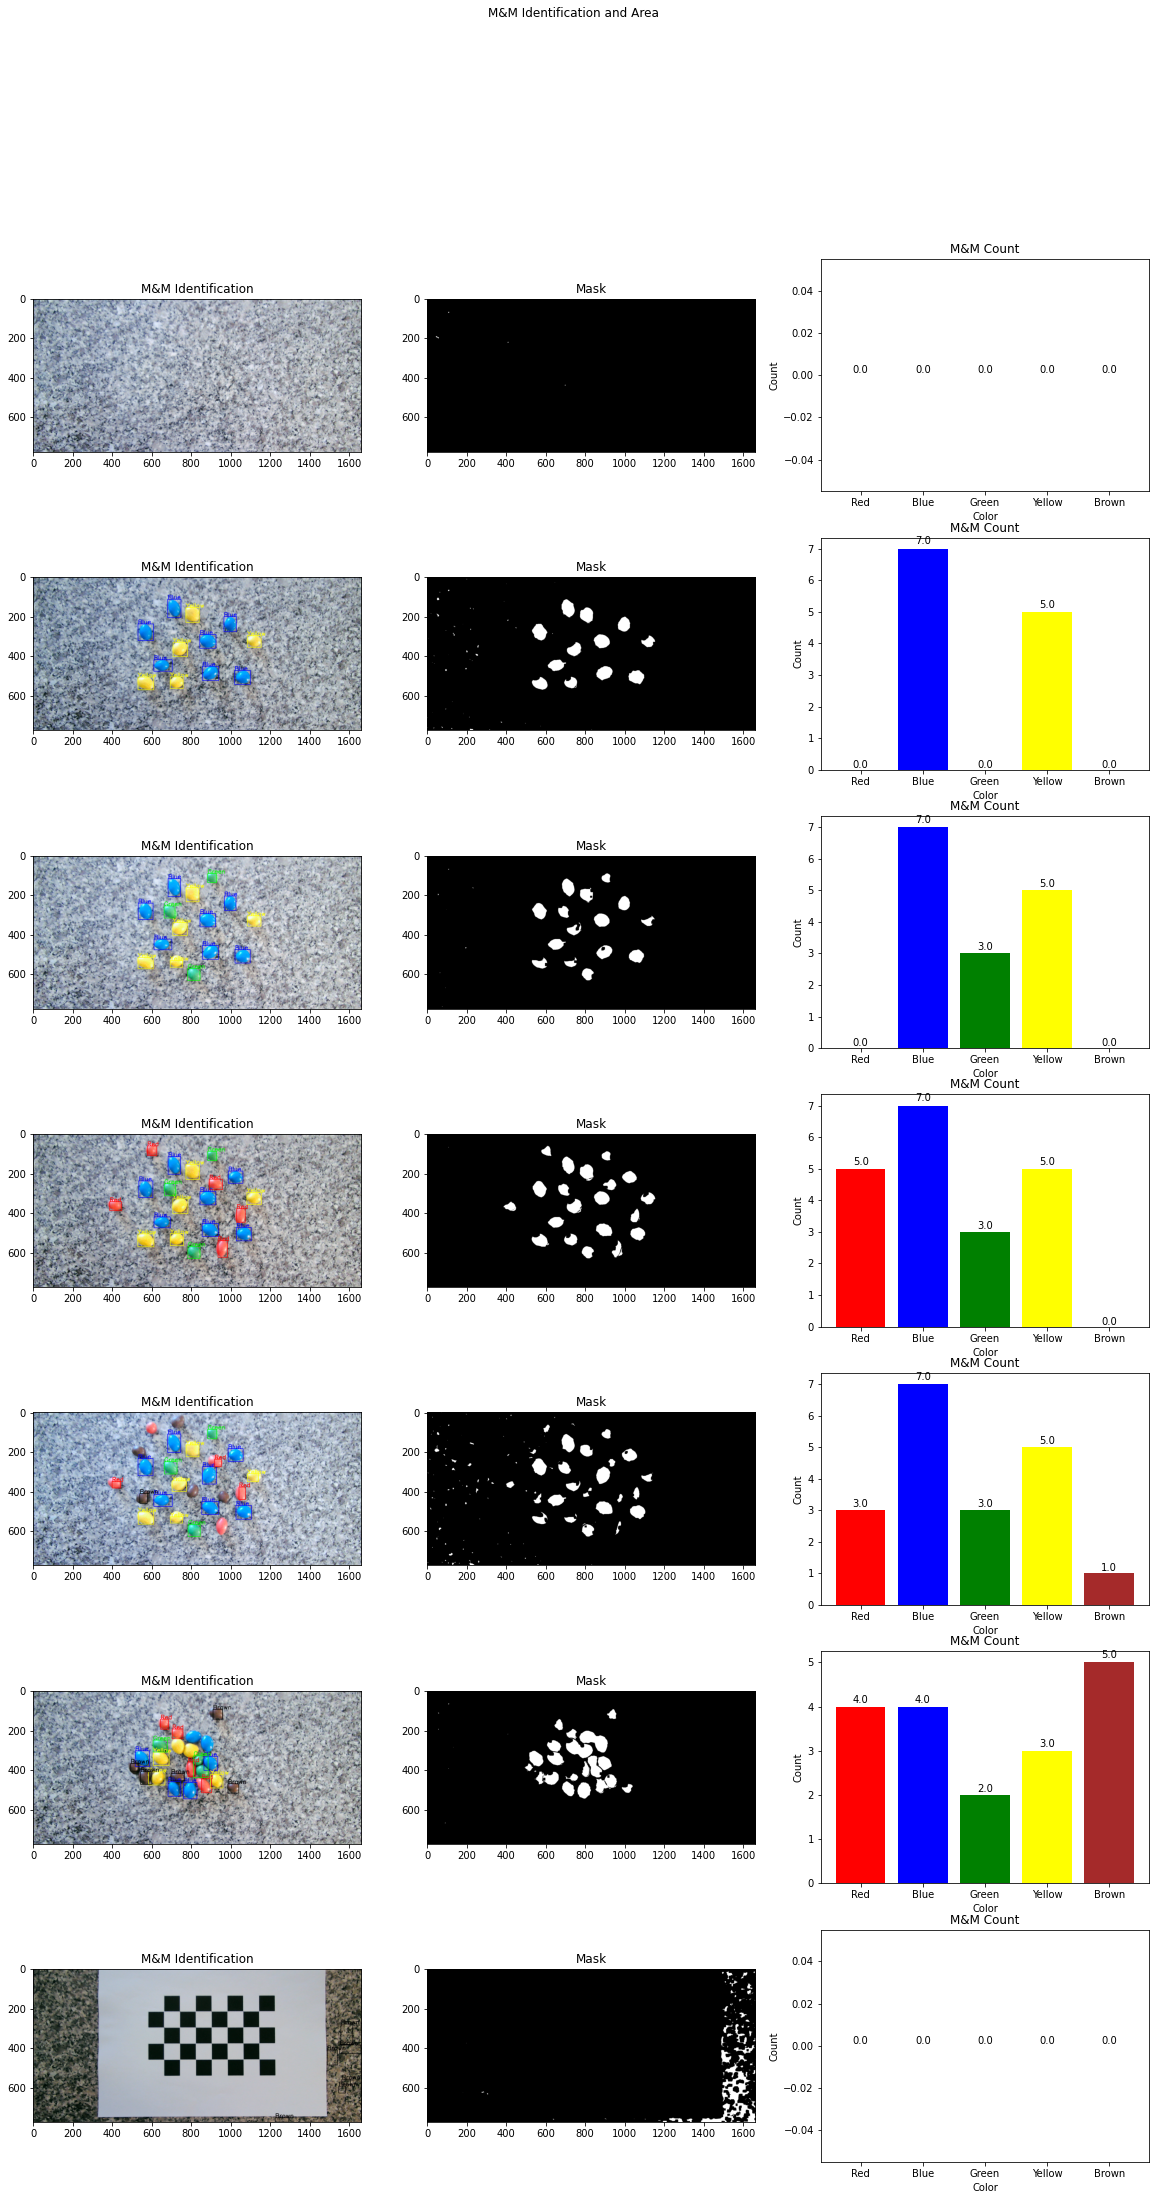

In [188]:
images = glob.glob('./Data/Grey/*.png')
fig, axes = matplotlib.pyplot.subplots(7, 3, figsize = (20,35), gridspec_kw={"width_ratios": [1, 1, 1]})
fig.suptitle("M&M Identification and Area")

area.clear()
areas_color.clear()
img_ID.clear()
contagem.clear()
i=0
for filename in images:

  img = cv.imread(filename)
  h,  w = img.shape[:2]
  newcameramtx, ROI = cv.getOptimalNewCameraMatrix(matrix, distortion, (w,h), 1, (w,h))
  # undistort
  dst = cv.undistort(img, matrix, distortion, None, newcameramtx)

  # crop the image
  x, y, w, h = ROI
  dst = dst[y:y+h, x:x+w]
  
  #ROI = dst[0:700, 360:1350]
  ROI = dst
  
  
  ROI_Filtered = cv.medianBlur(ROI,13)
  #cv2_imshow(ROI_Filtered)
  hsv = cv.cvtColor(ROI_Filtered, cv.COLOR_BGR2HSV)
  

  #Define masks
  red_mask = cv.inRange(hsv, red_lower, red_upper)
  red_mask = cv.dilate(red_mask, kernel_dilate)
  red_mask = cv.erode(red_mask, kernel_erode)


  blue_mask = cv.inRange(hsv, blue_lower, blue_upper)
  blue_mask = cv.dilate(blue_mask, kernel_dilate)
  blue_mask = cv.erode(blue_mask, kernel_erode)

  yellow_mask = cv.inRange(hsv, yellow_lower, yellow_upper)
  yellow_mask = cv.dilate(yellow_mask, kernel_dilate)
  yellow_mask = cv.erode(yellow_mask, kernel_erode)
  

  green_mask = cv.inRange(hsv, green_lower, green_upper)
  green_mask = cv.dilate(green_mask, kernel_dilate)
  green_mask = cv.erode(green_mask, kernel_erode)


  brown_mask = cv.inRange(hsv, brown_lower, brown_upper)
  brown_mask = cv.dilate(brown_mask, kernel_dilate)
  brown_mask = cv.erode(brown_mask, kernel_erode)
  #if(i == 6):
  #  matplotlib.pyplot.imshow(brown_mask)
  #matplotlib.pyplot.show()


                                                                
  (img_ID_Box, blue_cnt, blue_mask_area) = findObjects(ROI, blue_mask, objName = "Blue", IDBox_Color_BGR = (255, 0, 0))
  (img_ID_Box, red_cnt, red_mask_area) = findObjects(img_ID_Box, red_mask, objName = "Red", IDBox_Color_BGR = (0, 0, 255))
  (img_ID_Box, yellow_cnt, yellow_mask_area) = findObjects(img_ID_Box, yellow_mask, objName = "Yellow", IDBox_Color_BGR = (0, 255, 255))
  (img_ID_Box, green_cnt, green_mask_area) = findObjects(img_ID_Box, green_mask, objName = "Green", IDBox_Color_BGR = (0, 255, 0))
  (img_ID_Box, brown_cnt, brown_mask_area) = findObjects(img_ID_Box, brown_mask, objName = "Brown", IDBox_Color_BGR = (0, 0, 0))


  img_ID_Box = cv.cvtColor(img_ID_Box, cv.COLOR_BGR2RGB)

  img_ID.append(img_ID_Box.copy())
  
  area.append([])
  area[i].append(red_mask_area)
  area[i].append(blue_mask_area)
  area[i].append(green_mask_area)
  area[i].append(yellow_mask_area)
  area[i].append(brown_mask_area)

  contagem.append([])
  contagem[i].append(red_cnt)
  contagem[i].append(blue_cnt)
  contagem[i].append(green_cnt)
  contagem[i].append(yellow_cnt)
  if("extrinsic" in filename):
    brown_cnt = 0
  
  contagem[i].append(brown_cnt)

  

  axes[i][0].imshow(img_ID_Box)
  axes[i][0].set_title("M&M Identification")

  axes[i][1].imshow(blue_mask | red_mask | yellow_mask | green_mask | brown_mask, cmap = "gray")
  axes[i][1].set_title("Mask")

  plot = axes[i][2].bar(['Red', 'Blue', 'Green', 'Yellow', "Brown"], [red_cnt, blue_cnt, green_cnt, yellow_cnt, brown_cnt], color = ['red', 'blue', 'Green', 'yellow', "brown"])
  axes[i][2].set_xlabel("Color")
  axes[i][2].set_ylabel("Count")
  axes[i][2].set_title("M&M Count")
  
  #axes[i][2].bar(['Red', 'Blue', 'Green', 'Yellow'], [red_mask_area, blue_mask_area, green_mask_area, yellow_mask_area], color = ['red', 'blue', 'Green', 'yellow'])
  
  for rect in plot:
        height = rect.get_height()
        axes[i][2].text(rect.get_x() + rect.get_width()/2., 1.01*height,
                '%0.1f' % height, ha='center', va='bottom')
  i+=1
  



Text(0.5, 1.0, 'M&M Count by Size')

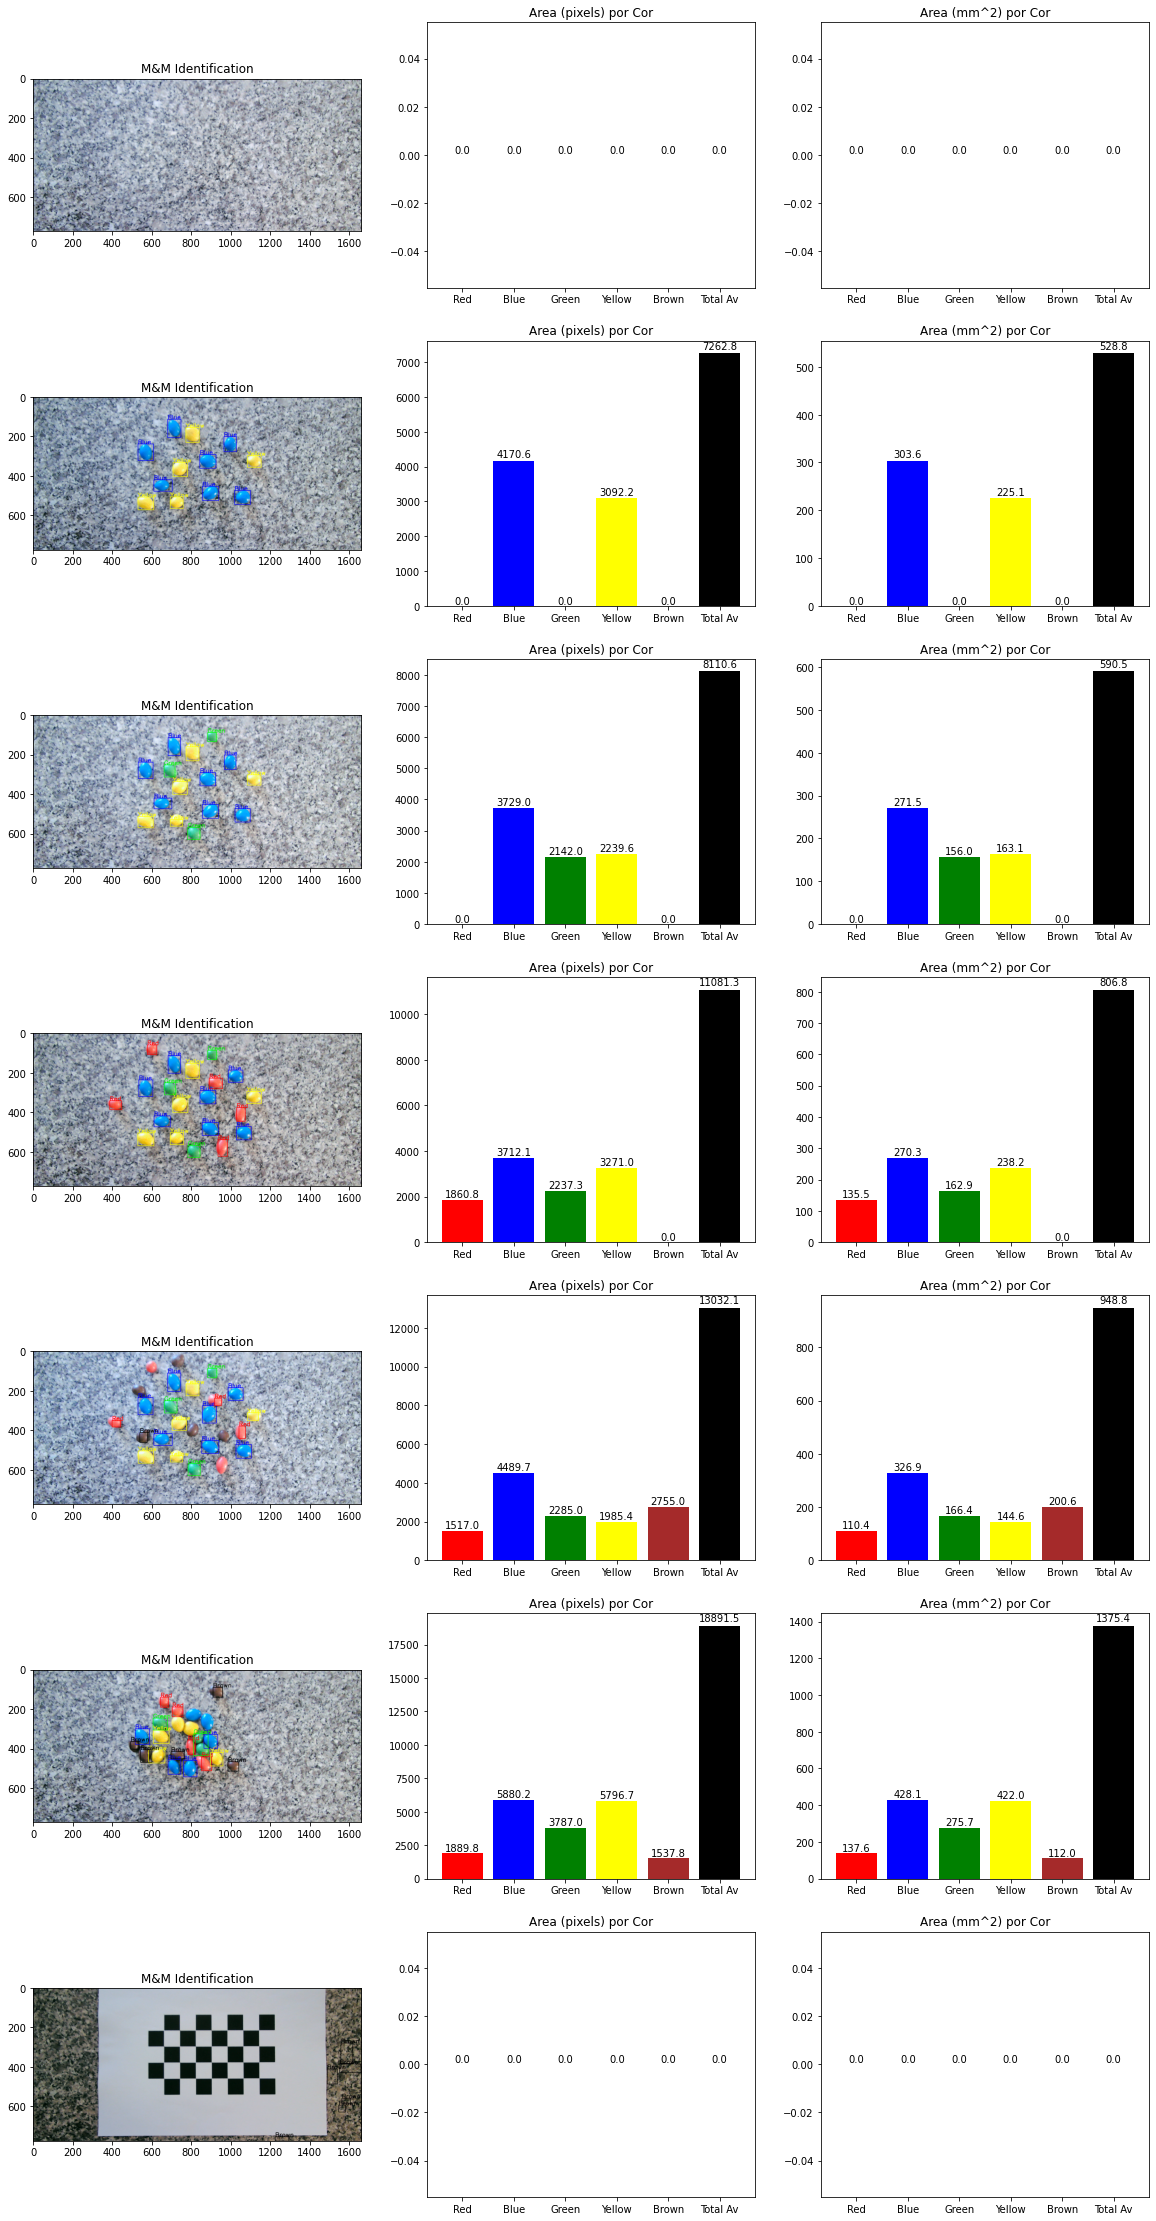

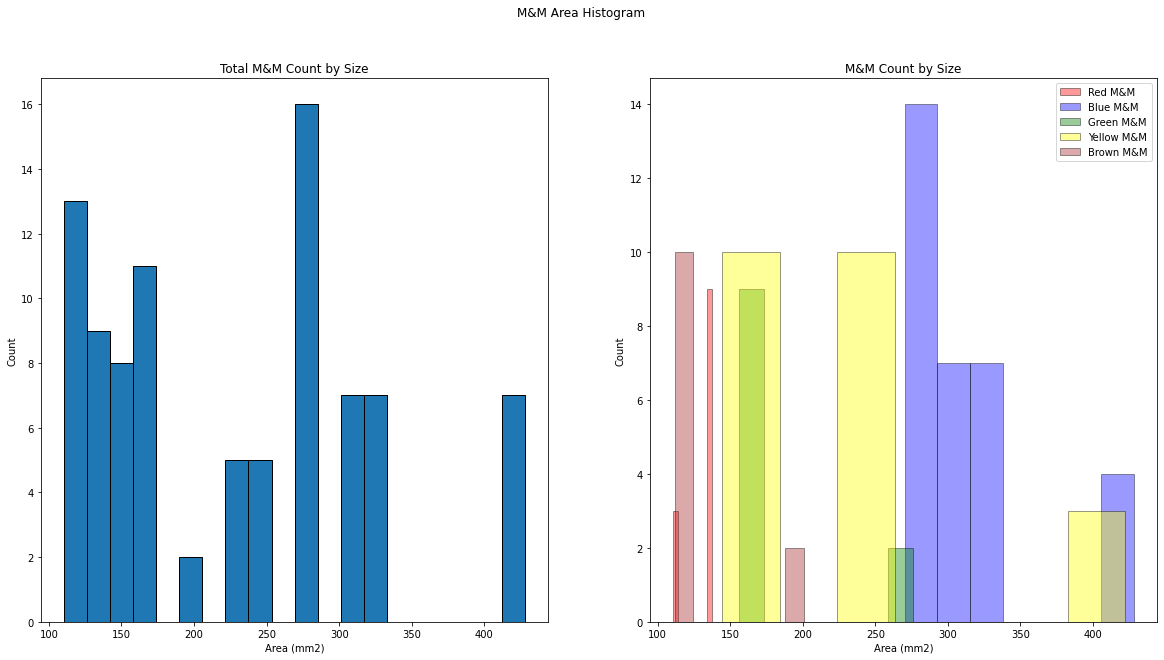

In [189]:
fig, axes = matplotlib.pyplot.subplots(7, 3, figsize = (20,40), gridspec_kw={"width_ratios": [1, 1, 1]})
fig_hist, axes_hist = matplotlib.pyplot.subplots(1, 2, figsize = (20,10))
fig_hist.suptitle("M&M Area Histogram")

areas = []
areas_color = [[],[],[],[],[]]

i=0
for filename in images:
  img = cv.imread(filename)
  h,  w = img.shape[:2]
  newcameramtx, ROI = cv.getOptimalNewCameraMatrix(matrix, distortion, (w,h), 1, (w,h))
  # undistort
  dst = cv.undistort(img, matrix, distortion, None, newcameramtx)

  # crop the image
  x, y, w, h = ROI
  dst = dst[y:y+h, x:x+w]
  
  #ROI = dst[0:700, 360:1350]
  ROI = dst

  
  if(contagem[i][0] > 0):
      area_red_pixels = area[i][0]/contagem[i][0]
  else:
      area_red_pixels = 0
  if(contagem[i][1] > 0):
      area_blue_pixels = area[i][1]/contagem[i][1]
  else:
      area_blue_pixels = 0    
  if(contagem[i][2] > 0):
      area_greeen_pixels = area[i][2]/contagem[i][2]
  else:
      area_greeen_pixels = 0
  if(contagem[i][3] > 0):
      area_yellow_pixels = area[i][3]/contagem[i][3]
  else:
      area_yellow_pixels = 0
  if(contagem[i][4] > 0):
      area_brown_pixels = area[i][4]/contagem[i][4]
  else:
      area_brown_pixels = 0
  


  areas.extend(area_red_pixels/const for _ in range(contagem[i][0]))
  areas_color[0].extend(area_red_pixels/const  for _ in range(contagem[i][0]))
  
  areas.extend(area_blue_pixels/const for _ in range(contagem[i][1]))
  areas_color[1].extend(area_blue_pixels/const for _ in range(contagem[i][1]))
  
  areas.extend(area_greeen_pixels/const for _ in range(contagem[i][2]))
  areas_color[2].extend(area_greeen_pixels/const for _ in range(contagem[i][2]))
 
  areas.extend(area_yellow_pixels/const for _ in range(contagem[i][3]))
  areas_color[3].extend(area_yellow_pixels/const for _ in range(contagem[i][3]))

  areas.extend(area_brown_pixels/const for _ in range(contagem[i][4]))
  areas_color[4].extend(area_brown_pixels/const for _ in range(contagem[i][4]))
  if ("extrinsic" in filename):
      area_brown_pixels = 0
  areas.extend(area_brown_pixels/const for _ in range(contagem[i][4]))
  areas_color[4].extend(area_brown_pixels/const for _ in range(contagem[i][4]))

  total = area_red_pixels + area_blue_pixels + area_greeen_pixels + area_yellow_pixels + area_brown_pixels


  axes[i][0].imshow(img_ID[i])
  axes[i][0].set_title("M&M Identification")

  rects = axes[i][1].bar(['Red', 'Blue', 'Green', 'Yellow', "Brown", "Total Av"], [area_red_pixels, area_blue_pixels, area_greeen_pixels, area_yellow_pixels, area_brown_pixels, total], color = ['red', 'blue', 'Green', 'yellow', "brown", "black"])
  axes[i][1].set_title("Area (pixels) por Cor")
  for rect in rects:
        height = rect.get_height()
        axes[i][1].text(rect.get_x() + rect.get_width()/2., 1.01*height,
                '%0.1f' % height, ha='center', va='bottom')
  
  
  rects = axes[i][2].bar(['Red', 'Blue', 'Green', 'Yellow', "Brown","Total Av"], [area_red_pixels/const, area_blue_pixels/const, area_greeen_pixels/const, area_yellow_pixels/const, area_brown_pixels/const, total/const], color = ['red', 'blue', 'Green', 'yellow', "brown", "black"])
  axes[i][2].set_title("Area (mm^2) por Cor")
  for rect in rects:
        height = rect.get_height()
        axes[i][2].text(rect.get_x() + rect.get_width()/2., 1.01*height,
                '%0.1f' % height, ha='center', va='bottom')
  
  i+=1


axes_hist[0].hist(x = areas, bins = 20, density = False, edgecolor="black")
axes_hist[0].set_xlabel("Area (mm2)")
axes_hist[0].set_ylabel("Count")
axes_hist[0].set_title("Total M&M Count by Size")

axes_hist[1].hist(x = areas_color[0], bins = 7, density = False, alpha = 0.4, color = "red", edgecolor="black", label="Red M&M")
axes_hist[1].hist(x = areas_color[1], bins = 7, density = False, alpha = 0.4, color = "blue", edgecolor="black", label="Blue M&M")
axes_hist[1].hist(x = areas_color[2], bins = 7, density = False, alpha = 0.4, color = "green", edgecolor="black", label="Green M&M")
axes_hist[1].hist(x = areas_color[3], bins = 7, density = False, alpha = 0.4, color = "yellow", edgecolor="black", label="Yellow M&M")
axes_hist[1].hist(x = areas_color[4], bins = 7, density = False, alpha = 0.4, color = "brown", edgecolor="black", label="Brown M&M")

axes_hist[1].legend()
axes_hist[1].set_xlabel("Area (mm2)")
axes_hist[1].set_ylabel("Count")
axes_hist[1].set_title("M&M Count by Size")
